In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\

import networkx as nx
import numpy as np
np.set_printoptions(precision=3)

import pandas as pd

from TCGAMultiOmics.multiomics import MultiOmicsData

from moge.network.heterogeneous_network import HeterogeneousNetwork
from moge.network.omics_distance import compute_expression_correlations, compute_annotation_similarity
from moge.visualization.plot import plot_matrix

# Heterogeneous Network

In [2]:
# READ Edgeslist
# network.import_edgelist_file(file="moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_node_similarity_99_50.edgelist", 
#                              directed=False)
# network.import_edgelist_file(file="moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_regulatory_interactions.edgelist", 
#                              directed=True)
# network.remove_extra_nodes()

In [3]:
# WRITE Edgelist
# nx.write_edgelist(network.get_subgraph(["MIR", "GE"]), 
#                   "moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_node_similarity_99_50.edgelist", 
#                   data=True)

# nx.write_edgelist(network.get_subgraph(["MIR", "GE"]), 
#                   "moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_regulatory_interactions.edgelist", 
#                   data=True)

In [4]:
import pickle

# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network.pickle', 'wb') as file:
#     pickle.dump(network, file)

with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.remove_extra_nodes()
    network.node_list = network.all_nodes

In [5]:
node_list = network.node_list

#  Split Network to train test and write to file

In [46]:
from moge.evaluation.utils import mask_test_edges
adj_train, train_edges, \
val_edges, test_edges = mask_test_edges(network.get_adjacency_matrix(edge_type='d', node_list=node_list), 
                                                 is_directed=True,
                                                 test_frac=.1, val_frac=.05,
                                                 prevent_disconnect=True, verbose=True)

preprocessing...
creating true edges...
edges in MST: 18383
Num WCC:  3790
Largest WCC num nodes:  18365
Largest WCC num edges:  354795
Fraction of train edges with both endpoints in L-WCC:  1.0
Fraction of test edges with both endpoints in L-WCC:  N/A
Fraction of val edges with both endpoints in L-WCC:  N/A
final checks for disjointness...
creating adj_train...
Done with train-test split!
Num train edges (true, ): ( 354795 , 
Num test edges (true, ): ( 0 , 
Num val edges (true, ): ( 0 , 


In [6]:
from moge.evaluation.utils import split_train_test_network

network_train, val_edges_dict, test_edges_dict = split_train_test_network(network, node_list, 
                                                          test_frac=.05, val_frac=.01, edge_type=["u", "d"], 
                                                          seed=0)

In [7]:
print("edges: ", network_train.get_subgraph(modalities=["MIR", "GE"]).number_of_edges())

edges:  375524


In [8]:
print("edges: ", network.get_subgraph(modalities=["MIR", "GE"]).number_of_edges())

edges:  375524


In [14]:
network_train.G.number_of_nodes()

22337

# Add Correlation edges

In [ ]:
mir_ge_corr = network.compute_multiomics_correlations(modalities=["MIR", "GE"])

## Network Info & Visualizations

In [23]:
print("isolated nodes:", len(nx.isolates(network.get_subgraph(modalities=["MIR", "GE"]))),
      ", out of total nodes:", network.all_nodes.__len__())
print("edges: ", network.get_subgraph(modalities=["MIR", "GE"]).number_of_edges())

isolated nodes: 1988 , out of total nodes: 22342
edges:  12171466


In [ ]:
print(len(network.G.nodes()))
print(len(network.G.edges()))
# print(luad_data.LNC.get_genes_list())

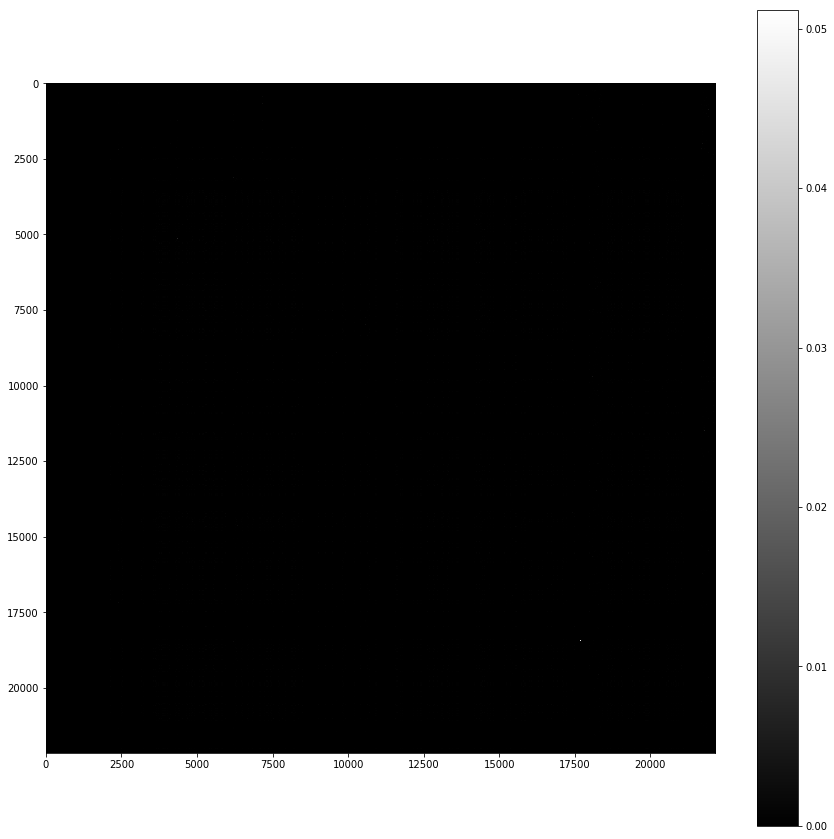

In [40]:
# Scatter plot of original graph adjacency matrix
plt.figure(figsize=(15, 15))
plt.imshow(graph_emb.get_reconstructed_adj(edge_type="u"), interpolation='none', cmap=plt.cm.gray)
plt.colorbar()
plt.show()

# Training Source Target Graph Embedding

In [92]:
import tensorflow as tf
tf.reset_default_graph()
sess.close()
sess = tf.InteractiveSession()

In [93]:
with tf.name_scope('inputs'):
    E_i_ = tf.sparse_placeholder(tf.float32, name="E_i_")
    is_directed = tf.placeholder(tf.bool, name="is_directed")
    i = tf.Variable(int, name="i", trainable=False)


emb_s = tf.Variable(initial_value=tf.random_uniform([len(network.all_nodes), 64], -1, 1),
                         validate_shape=True, dtype=tf.float32,
                         name="emb_s", trainable=True)

emb_t = tf.Variable(initial_value=tf.random_uniform([len(network.all_nodes), 64], -1, 1),
                         validate_shape=True, dtype=tf.float32,
                         name="emb_s", trainable=True)

emb_c = tf.concat([emb_s, emb_t], axis=1, name="emb_concat")

# 1st order (directed proximity)
p_1 = tf.sigmoid(tf.matmul(tf.slice(emb_s, [i, 0], [1, emb_s.get_shape()[1]]),
                           emb_t,
                           transpose_b=True, name="p_1_inner_prod"), name="p_1")
# print("E_i_:", E_i_)
# print("p_1:", p_1)
# print("tf.sparse_tensor_dense_matmul(E_i_, tf.log(p_1)):", tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_1)), ))

loss_f1 = tf.reduce_sum(-tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_1))), name="loss_f1")

# 2nd order proximity
p_2_exps = tf.matmul(tf.slice(emb_c, [i, 0], [1, emb_c.get_shape()[1]], name="p_2_exps_i"),
                    emb_c,
                    transpose_b=True) # dim (1, n_nodes)
p_2 = tf.nn.softmax(p_2_exps - tf.reduce_max(p_2_exps, axis=1),
                             axis=1, name="p_2_softmax")
# print("p_2:", p_2)
# print("tf.sparse_tensor_dense_matmul(E_i_, tf.log(p_2)):", tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_2))))
loss_f2 = tf.reduce_sum(-tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_2))), name="loss_f2")

loss = tf.cond(is_directed, true_fn=lambda: loss_f1, false_fn=lambda: loss_f2)

# Add the loss value as a scalar to summary.
tf.summary.scalar('loss', loss)
# tf.summary.scalar("E_i_.dense_shape", E_i_.dense_shape)
merged = tf.summary.merge_all()

# Initialize variables
init_op = tf.global_variables_initializer()

# SGD Optimizer
optimizer = tf.train.GradientDescentOptimizer(0.1)\
    .minimize(loss, var_list=[emb_s, emb_t])

sess.run(init_op)

In [83]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return indices, coo.data, coo.shape


In [17]:
adj = network.get_regulatory_edges_adjacency()

In [58]:
Ed_rows, Ed_cols = adj.nonzero()
Ed_random_idx = list(np.unique(Ed_rows))

In [94]:
idx=3
Ed_i_sparse = convert_sparse_matrix_to_sparse_tensor(adj[idx, :])
feed_dict = {E_i_: Ed_i_sparse, is_directed: True, i: idx}
feed_dict

{<tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fcdc32aa828>: (matrix([[    0,  1871],
          [    0,  1886],
          [    0,  1894],
          ...,
          [    0, 22136],
          [    0, 22141],
          [    0, 22151]], dtype=int32),
  array([0.49, 0.59, 1.  , ..., 0.57, 1.  , 1.  ]),
  (1, 22154)),
 <tf.Tensor 'inputs/is_directed:0' shape=<unknown> dtype=bool>: True,
 <tf.Variable 'inputs/i:0' shape=() dtype=int32_ref>: 3}

In [95]:
sparse_matmul_1 = tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_1)))

In [96]:
_, summary, loss_val, a1, a2, a3 = sess.run([optimizer, merged, loss, p_1, p_2, sparse_matmul_1], feed_dict=feed_dict)
print(loss_val, a1.shape, a2.shape, a3.shape)

1493.6848 (1, 22154) (1, 22154) (1, 1)


# Training SourceTargetGraphEmbedding

In [57]:
from moge.embedding.siamese_dual_embedding import SiameseGraphEmbedding

graph_emb = SiameseGraphEmbedding(d=64, lr=0.1, Ed_Eu_ratio=0.1, epochs=5, batch_size=5000)
graph_emb.learn_embedding(network, seed=0)


KeyboardInterrupt: 

In [11]:
graph_emb.import_embedding("/home/jonny_admin/PycharmProjects/MultiOmicsGraphEmbedding/moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_source_target_embeddings_128.embeddings",
                          node_list=network.all_nodes)
# graph_emb.save_embeddings("miRNA-mRNA_source_target_embeddings_128.embeddings")

In [47]:
adj = graph_emb.get_reconstructed_adj(edge_type='d')

In [49]:
from moge.evaluation.link_prediction import largest_indices, select_top_k_link_predictions
adj[select_top_k_link_predictions(100000, adj, train_edges)]

array([1.   , 1.   , 1.   , ..., 0.999, 0.999, 0.999], dtype=float32)

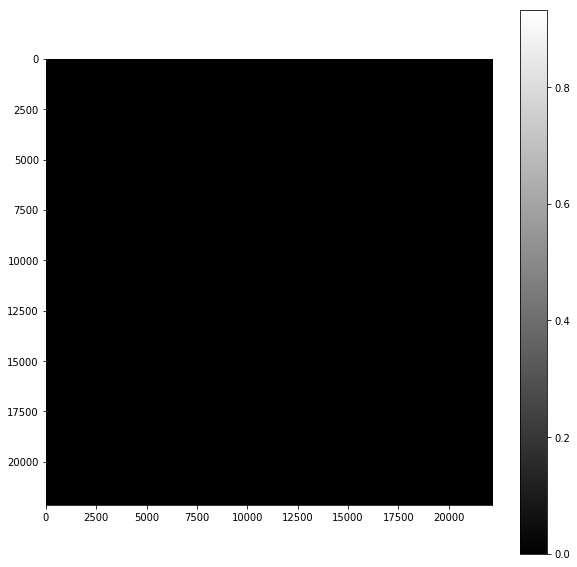

In [53]:
plot_matrix(graph_emb.get_reconstructed_adj(edge_type='u'), colorbar=True)
# plot_matrix(adj, colorbar=True)

# Import different models

In [21]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("/home/jonny_admin/PycharmProjects/OpenNE/miRNA-mRNA_LINE.txt", 
                          node_list=network.all_nodes)

# node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
# node2vec_emb.import_embedding("/home/jonny_admin/PycharmProjects/OpenNE/vec_all_node2vec.txt", 
#                           node_list=network.all_nodes)

# node_list = list(set(line_emb.node_list) & set(node2vec_emb.node_list))

In [9]:
models = []
models.append(graph_emb)
# models.append(line_emb)
# models.append(node2vec_emb)

In [23]:
from gem.embedding.gf       import GraphFactorization
from gem.embedding.hope     import HOPE
from gem.embedding.lap      import LaplacianEigenmaps
from gem.embedding.lle      import LocallyLinearEmbedding
from gem.embedding.node2vec import node2vec
from gem.embedding.sdne     import SDNE

# You can comment out the methods you don't want to run
# models.append(HOPE(d=100, beta=0.1))
models.append(GraphFactorization(d=128, max_iter=100, eta=1*10**-4, regu=1.0))
# models.append(LaplacianEigenmaps(d=200))
models.append(LocallyLinearEmbedding(d=128))
models.append(node2vec(d=128, max_iter=10, walk_len=5, num_walks=10, con_size=10, ret_p=1, inout_p=1))
# models.append(SDNE(d=200, beta=5, alpha=1e-5, nu1=1e-6, nu2=1e-6, 
#                    K=3, n_units=[50, 15,], rho=0.3, 
#                    n_iter=100, xeta=0.01, n_batch=500))

# models.append(DualGraphEmbedding(d=100, reg=1.0, lr=0.05, iterations=100))
                   

# Evaluate Graph Reconstruction

In [11]:
# node_list = list(set(line_emb.node_list) & set(graph_emb.node_list))
node_list = network.node_list
print(len(node_list))

22154


In [12]:
from moge.evaluation.graph_reconstruction import evaluateStaticGraphReconstruction
# Directed edges
for model in models:
    print("\n",model.get_method_name())
    norm, avg = evaluateStaticGraphReconstruction(network, model, edge_type="d", sample_ratio=1.0, 
                                             node_list=node_list)

    print(norm, avg)


 source_target_graph_embedding
Sampling 354795 edges to be evaluated.


AttributeError: 'SubDiGraph' object has no attribute 'node_list'

In [105]:
# Undirected edges
for model in models:
    print("\n",model.get_method_name())
    norm, avg = evaluateStaticGraphReconstruction(network, model, edge_type="u", sample_ratio=1.0, 
                                             node_list=node_list)
    print(norm, avg)


 source_target_graph_embedding
Sampling 355150 edges to be evaluated.
312.87635394572385 0.41637715777956286

 LINE
Sampling 355150 edges to be evaluated.
218.32465358288118 0.13672804522245333

 node2vec
Sampling 355150 edges to be evaluated.


IndexError: index 18765 is out of bounds for axis 0 with size 18755

# Evaluate Link Prediction

In [26]:
from moge.evaluation.link_prediction import evaluate_top_k_link_prediction, evaluate_random_link_prediction
from moge.embedding.dual_graph_embedding import SourceTargetGraphEmbedding

# Directed edges
for model in models:
    print("\n",model.get_method_name())
    scores = evaluate_top_k_link_prediction(top_k=1000, network=network, node_list=node_list,
                                 graph_emb=model, train_embedding=False,
                                 edge_type="d", test_frac=0.001, seed=0)
    print(scores)


 source_target_graph_embedding
test_edges: 354
{'precision': 0.0, 'recall': 0.0}

 LINE
test_edges: 354


IndexError: index 20238 is out of bounds for axis 0 with size 20171

In [13]:
# Undirected edges
for model in models:
    evaluate_top_k_link_prediction(top_k=100000, network=network, 
                             graph_emb=model, train_embedding=False,
                             edge_type="u", test_frac=0.001, seed=0)
    print(scores)

test_edges: 11755
top k predicted edges: [0.204 0.152 0.15  ... 0.001 0.001 0.001]


{'precision': 0.010771615742361355, 'recall': 0.09167517875383044}

In [41]:
# Evaluate random directed edge prediction
print(evaluate_random_link_prediction(top_k=10000, network=network, edge_type="d", test_frac=0.001, seed=0))
print(evaluate_random_link_prediction(top_k=100000, network=network, edge_type="u", test_frac=0.00001, seed=0))

{'precision': 0.0, 'recall': 0.0}
{'precision': 0.0, 'recall': 0.0}


# Import GEM Graph Embedding Methods

In [42]:
from gem.utils import graph_util, plot_util
from gem.evaluation import visualize_embedding as viz
from gem.evaluation import evaluate_graph_reconstruction as gr
from gem.evaluation.metrics import getPrecisionReport
from gem.evaluation.evaluate_link_prediction import evaluateStaticLinkPrediction

from time import time

from gem.embedding.gf       import GraphFactorization
from gem.embedding.hope     import HOPE
from gem.embedding.lap      import LaplacianEigenmaps
from gem.embedding.lle      import LocallyLinearEmbedding
from gem.embedding.node2vec import node2vec
from gem.embedding.sdne     import SDNE
from moge.embedding.dual_graph_embedding import DualGraphEmbedding


Using TensorFlow backend.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'In file included from /usr/local/cuda-9.0/include/channel_descriptor.h:62:0,\n                 from /usr/local/cuda-9.0/include/cuda_runtime.h:90,\n                 from /usr/include/cudnn.h:64,\n                 from /tmp/try_flags_sy4bbgau.c:4:\n/usr/local/cuda-9.0/include/cuda_runtime_api.h:2930:102: error: use of enum \xe2\x80\x98cudaFuncAttribute\xe2\x80\x99 without previous declaration\n extern __host__ __cudart_builtin__ cudaError_t CUDARTAPI cudaFuncSetAttribute(const void *func, enum cudaFuncAttribute attr, int value);\n                                                                                                      ^~~~~~~~~~~~~~~~~\n'
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:01:00.0)


In [55]:
print ('Num nodes: %d, num edges: %d' % (G.number_of_nodes(), G.number_of_edges()))
for embedding in models:
    try:
        print("\n", embedding.get_method_name(), embedding.get_method_summary())
        t1 = time()
        
    #     Learn embedding - accepts a networkx graph or file with edge list
        embedding.learn_embedding(graph=G, edge_f=None, is_weighted=True, no_python=True)
        print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))

        Y = embedding.get_embedding()

#         # Evaluate on graph reconstruction
        MAP, prec_curv, err, err_baseline = gr.evaluateStaticGraphReconstruction(G, embedding, Y, 
                                                                                 sample_ratio_e=0.0001, k=500000)
        print ("Graph Reconstruction. MAP:", MAP)

        
        # Evaluate on link prediction
#         MAP, prec_curv = evaluateStaticLinkPrediction(G, embedding,
#                                      train_ratio=0.8,
#                                      is_undirected=False)
#         print ("Link Prediction. MAP:", MAP)
#         print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))
        
        # Visualize
#         viz.plot_embedding2D(embedding.get_embedding(), di_graph=G, node_colors=None)
#         plt.show()
    except Exception as e:
        print("could not run", embedding, e)

Num nodes: 23179, num edges: 199324

 lap_eigmap_svd lap_eigmap_svd_200
Laplacian matrix recon. error (low rank): 118.058668
lap_eigmap_svd:
	Training time: 156.647702


KeyboardInterrupt: 

# Node Visualization

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2)
node_pos = model.fit_transform(models[0].get_embedding())
pos = {}
for i in range(len(G.nodes())):
    pos[i] = node_pos[i, :]
nx.draw_networkx(G, pos, width=0.1, node_size=300, arrows=False,
                             alpha=0.8, font_size=12)